In [1]:
import qutip as qt
import numpy as np
import matplotlib.pyplot as plt
import sys
import matplotlib as mpl
from matplotlib import ticker
import seaborn as sns 
sys.path.append('/Users/omichel/Desktop/qilimanjaro/projects/scattering/domain_wall_scattering/src')

from DynamicsDefinition import Hamiltonian
from model_building import initialize_system
from dynamics import time_evolution, single_qubit_expectation_values, two_qubit_expectation_values
from plots import plot_expectations, plot_heatmap, plot_correlation_heatmap
from data_handling import save_numpy_array, fetch_numpy_array

# Heat map of transmission as a function of potential barrier size and dephasing time

This notebook contains simulations and plots of a scattering experiment and it shows the different relevant magnitudes of the outcome:

- Min value of <Z> in the last qubit
- Fraction of transmission of excitation to the last qubit

We present it in different forms:

- 2D heatmap with all the data
- Plots with several curves corresponding to different barrier sizes or dephasings

Additionally, we do the simulations for uniform Heisenberg chains and perfect transport inhomogenous chains

## Parameter definition

For the Heisenberg chain

In [14]:
N = 5
lmd = 0.02272
J = 1

V_index = 3
state_dictionary = {'0':1}
ti = 0
tf = np.pi/lmd*1.5
nstep = 500
environment = True


V = np.linspace(0, 5*lmd, 101)
# T2 = np.linspace(10, 10000, 11)
T2 = np.exp(np.linspace(np.log(50), np.log(10000), 101))

min_z_last_qubit = np.zeros((len(T2), len(V)))


initial_state, final_state, reg_size = initialize_system(state_dictionary, N, encoding='domain_wall', one_step=False)


## Main loop

In [64]:
for i, t2_i in enumerate(T2):
    gamma = 1/t2_i
    dephasing_rates = N*[gamma]
    for j, pot_j in enumerate(V):
        H = Hamiltonian(N, lmd, J, pot_j, V_index)
        simulation = time_evolution(H, initial_state, ti, tf, nstep, dephasing_rates, environment)
        exp_values = single_qubit_expectation_values(simulation, H)
        min_z_last_qubit[i, j] = min(exp_values['Sz'][:,-1])

/Users/omichel/.pyenv/versions/environment/lib/python3.14/site-packages/qutip/solver/solver_base.py:598: FutureWarning: e_ops will be keyword only from qutip 5.3 for all solver
  warnings.warn(


In [3]:
#Save data
filepath = "/Users/omichel/Desktop/qilimanjaro/projects/scattering/files/data/heat_map_101_101"
save_numpy_array(min_z_last_qubit, filepath)

FileExistsError: File '/Users/omichel/Desktop/qilimanjaro/projects/scattering/files/data/heat_map_101_101.npy' already exists. Operation aborted to prevent overwriting.

In [15]:
#Load data
filepath = "/Users/omichel/Desktop/qilimanjaro/projects/scattering/files/data/heat_map_101_101"
min_z_last_qubit = fetch_numpy_array(filepath)

## Plot magnitudes

In [16]:
x_plot = V/lmd
y_plot = T2/tf

def calculate_transmission(data):
    transmission = np.zeros((len(T2), len(V)))
    max_z_diff = 1 - min(data[-1])
    for i in range(len(data)):
        for j in range(len(data[i,:])):
            transmission[i,j] = ((1 - data[i,j])/max_z_diff)
    return transmission

transmission = calculate_transmission(min_z_last_qubit)



## Plot configuration of heat map

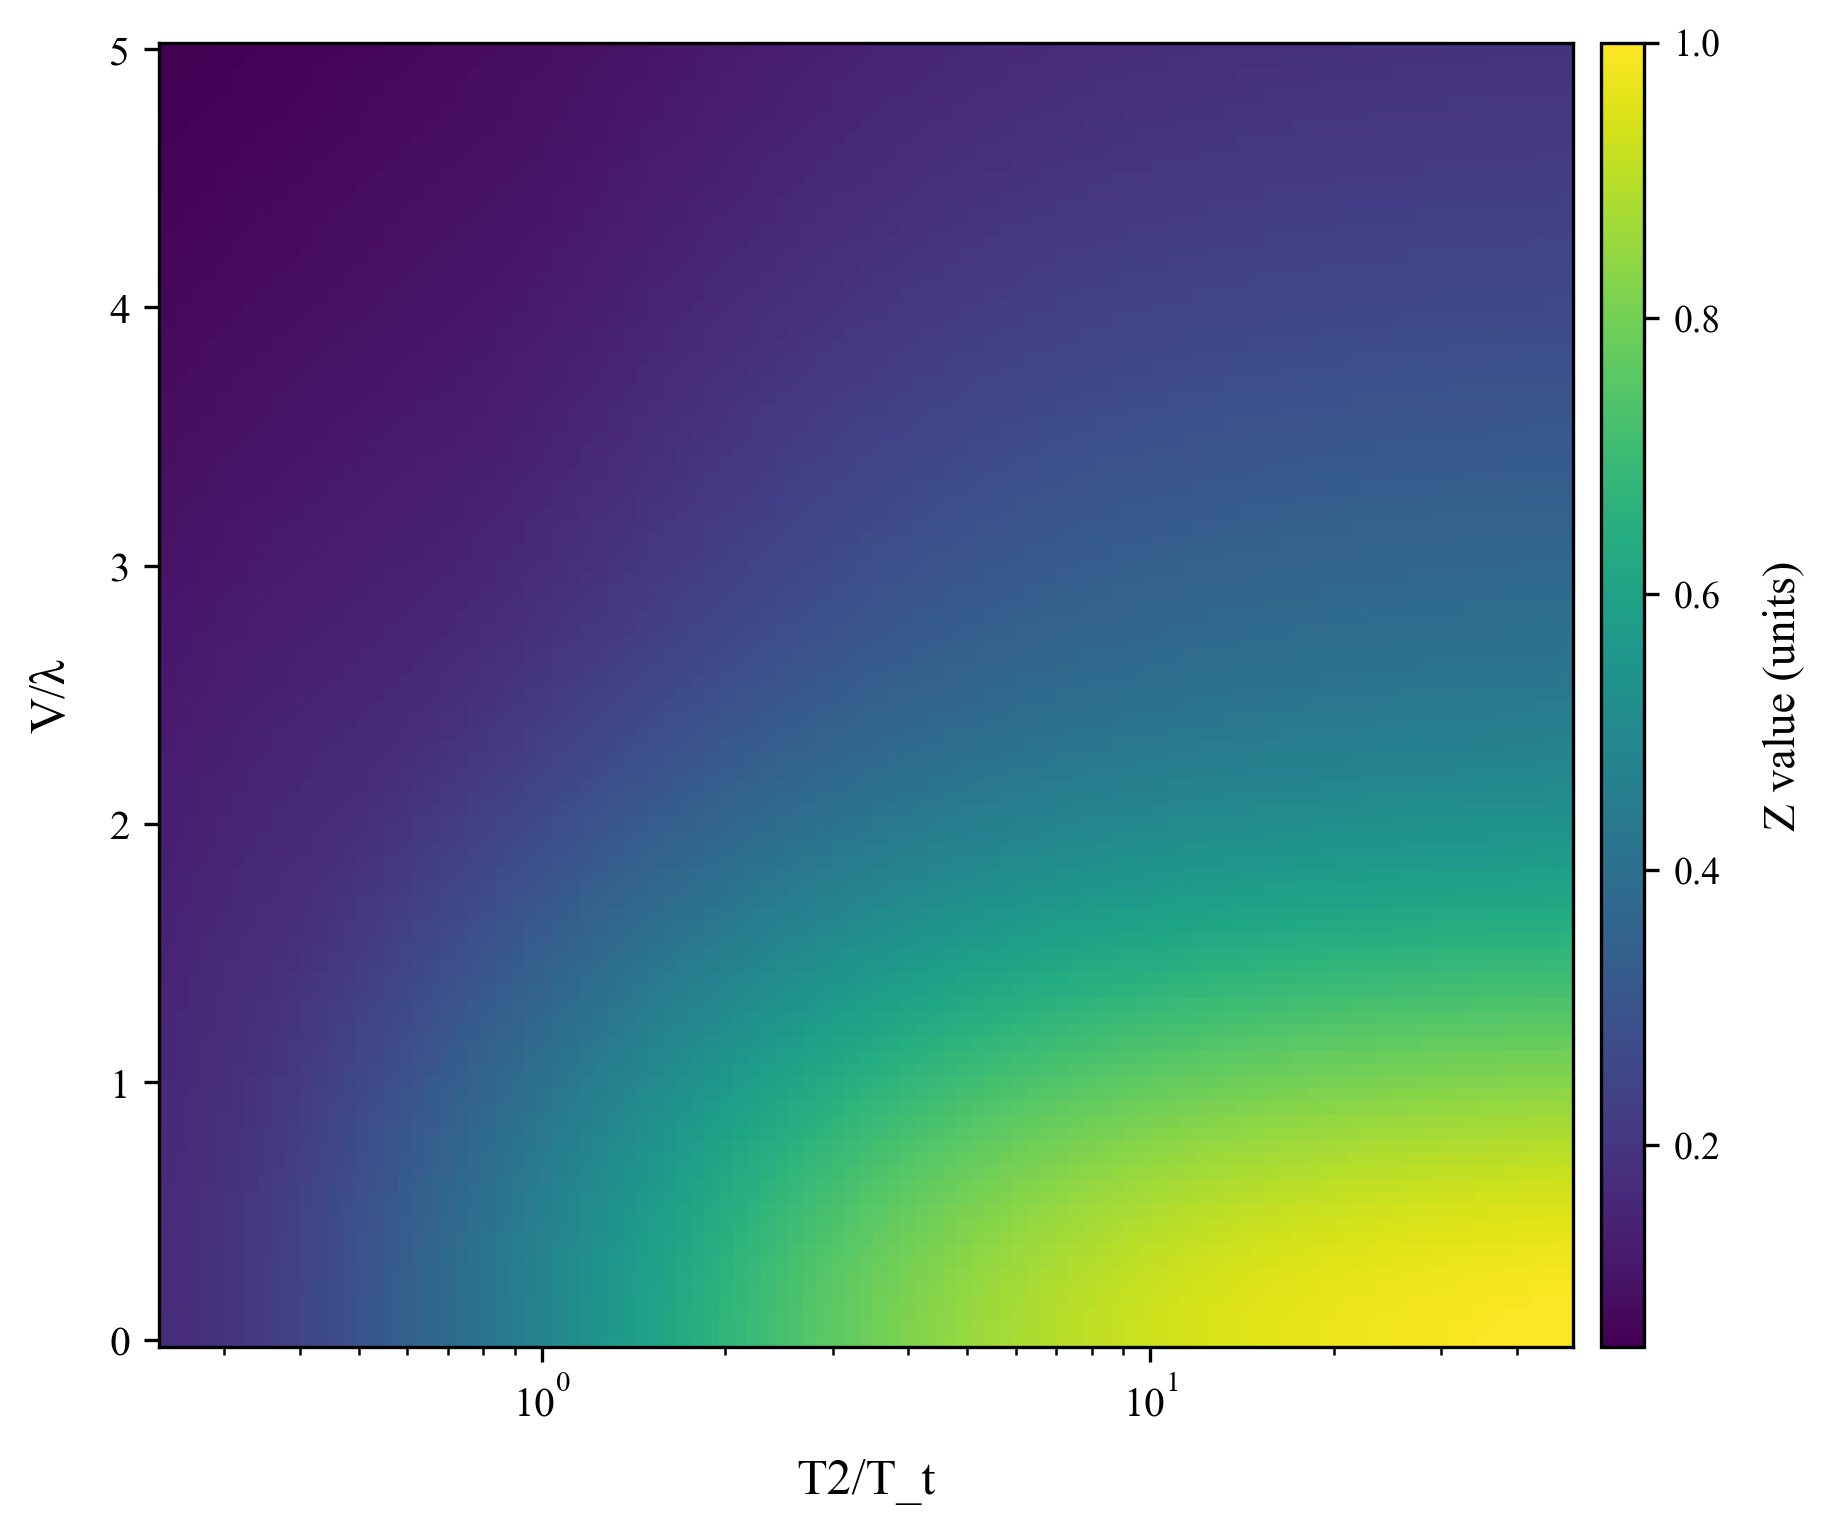

"\nFOR SCIENTIFIC PUBLICATIONS:\n\n1. COLOR MAP CHOICE:\n   - Sequential data: 'viridis', 'plasma', 'inferno', 'magma'\n   - Diverging data: 'RdBu_r', 'coolwarm', 'seismic', 'bwr'\n   - Categorical: 'tab20c', 'Set3'\n   - Avoid: 'jet', 'rainbow' (perceptually non-uniform)\n\n2. ACCESSIBILITY:\n   - Test if plot is interpretable in grayscale\n   - Use colorblind-friendly palettes\n   - Consider adding patterns or textures if critical distinctions are needed\n\n3. DATA ASPECT RATIO:\n   - Set equal aspect if x and y have same units: ax.set_aspect('equal')\n   - Otherwise: ax.set_aspect('auto') (default)\n\n4. LEGEND/COLORBAR:\n   - Always include units in colorbar label\n   - Use appropriate number of significant figures\n   - Consider log scale if data spans orders of magnitude:\n        from matplotlib.colors import LogNorm\n        norm = LogNorm(vmin=Z.min(), vmax=Z.max())\n        heatmap = ax.pcolormesh(..., norm=norm)\n\n5. ANNOTATIONS:\n   - Label subfigures (A, B, C) if part of 

In [17]:
# ========== CONFIGURATION FOR SCIENTIFIC PLOTS ==========
# Set publication-quality parameters
plt.rcParams.update({
    'font.family': 'serif',  # or 'sans-serif' depending on journal
    'font.serif': ['Times New Roman', 'DejaVu Serif', 'Computer Modern Roman'],
    'font.size': 11,  # Base font size
    'axes.labelsize': 12,  # Axis label size
    'axes.titlesize': 14,  # Title size
    'legend.fontsize': 10,  # Legend size
    'xtick.labelsize': 10,  # X-tick label size
    'ytick.labelsize': 10,  # Y-tick label size
    'figure.dpi': 300,  # High resolution
    'savefig.dpi': 300,
    'savefig.bbox': 'tight',
    'savefig.pad_inches': 0.1,
    'figure.autolayout': False,  # Use constrained_layout instead
    'mathtext.fontset': 'stix',  # For LaTeX-like math fonts
})

# ========== DATA GENERATION (REPLACE WITH YOUR DATA) ==========
# Create sample data grid
X, Y = np.meshgrid(x_plot, y_plot)

# Z data (chose magnitude to be represented)

#Z = min_z_last_qubit
Z = transmission

# ========== FIGURE INITIALIZATION ==========
fig, ax = plt.subplots(figsize=(6, 5), constrained_layout=True)
# Common aspect ratios for papers: 1:1, 4:3, or golden ratio (1.618:1)

ax.set_xscale('log')

# ========== CREATE HEATMAP ==========
# Using pcolormesh (better for irregular grids) or imshow (for regular grids)
heatmap = ax.pcolormesh(Y, X, Z, 
                       cmap='viridis',  # Consider: 'viridis', 'plasma', 'inferno', 'RdBu_r', 'coolwarm'
                       shading='auto',  # 'auto', 'nearest', 'gouraud'
                       edgecolors='none',  # Remove grid lines between cells
                       linewidth=0,
                       rasterized=True)  # Makes PDF files smaller

# ========== COLORBAR CONFIGURATION ==========
cbar = fig.colorbar(heatmap, ax=ax, pad=0.02, aspect=30)
cbar.set_label('Z value (units)', fontsize=11, labelpad=10)
cbar.ax.tick_params(labelsize=9)
# Optional: set specific colorbar ticks
# cbar.set_ticks([Z.min(), Z.max()/2, Z.max()])
# cbar.set_ticklabels(['Low', 'Medium', 'High'])

# ========== AXES AND LABELS ==========
ax.set_xlabel('T2/T_t', fontsize=12, labelpad=8)
ax.set_ylabel('V/λ', fontsize=12, labelpad=8)

# Optional title (often omitted in papers with figure captions)
# ax.set_title('Descriptive Title', fontsize=14, pad=12)

# Set axis limits if needed
# ax.set_xlim([x.min(), x.max()])
# ax.set_ylim([y.min(), y.max()])

# Adjust tick frequency and formatting
# ax.xaxis.set_major_locator(ticker.MaxNLocator(6))  # ~6 major ticks
# ax.yaxis.set_major_locator(ticker.MaxNLocator(6))
# ax.xaxis.set_minor_locator(ticker.AutoMinorLocator(2))  # 2 minor ticks per major
# ax.yaxis.set_minor_locator(ticker.AutoMinorLocator(2))

# Format tick labels if needed (e.g., scientific notation)
# ax.ticklabel_format(style='sci', axis='both', scilimits=(0,0))
# ax.xaxis.get_offset_text().set_fontsize(9)
# ax.yaxis.get_offset_text().set_fontsize(9)

# Grid (optional, usually omitted in heatmaps)
# ax.grid(True, which='major', linestyle='--', alpha=0.3, linewidth=0.5)

# ========== ADDITIONAL ANNOTATIONS ==========
# Add text annotations if needed
# ax.text(0.05, 0.95, 'A', transform=ax.transAxes, 
#         fontsize=16, fontweight='bold', va='top')

# Mark specific points or regions
# ax.scatter([5], [0], color='red', s=50, zorder=5, label='Maximum')
# ax.axhline(y=0, color='gray', linestyle='--', linewidth=0.8, alpha=0.7)
# ax.axvline(x=5, color='gray', linestyle='--', linewidth=0.8, alpha=0.7)

# ========== SAVE FIGURE ==========
# Choose appropriate format based on journal requirements
save_path = 'heatmap_figure.png'  # or .pdf, .eps, .tiff
# fig.savefig(save_path, dpi=300, bbox_inches='tight', pad_inches=0.05)

# Also save as vector format for editing
# fig.savefig('heatmap_figure.pdf', format='pdf', bbox_inches='tight')

plt.show()

# ========== ADDITIONAL CONSIDERATIONS ==========
"""
FOR SCIENTIFIC PUBLICATIONS:

1. COLOR MAP CHOICE:
   - Sequential data: 'viridis', 'plasma', 'inferno', 'magma'
   - Diverging data: 'RdBu_r', 'coolwarm', 'seismic', 'bwr'
   - Categorical: 'tab20c', 'Set3'
   - Avoid: 'jet', 'rainbow' (perceptually non-uniform)

2. ACCESSIBILITY:
   - Test if plot is interpretable in grayscale
   - Use colorblind-friendly palettes
   - Consider adding patterns or textures if critical distinctions are needed

3. DATA ASPECT RATIO:
   - Set equal aspect if x and y have same units: ax.set_aspect('equal')
   - Otherwise: ax.set_aspect('auto') (default)

4. LEGEND/COLORBAR:
   - Always include units in colorbar label
   - Use appropriate number of significant figures
   - Consider log scale if data spans orders of magnitude:
        from matplotlib.colors import LogNorm
        norm = LogNorm(vmin=Z.min(), vmax=Z.max())
        heatmap = ax.pcolormesh(..., norm=norm)

5. ANNOTATIONS:
   - Label subfigures (A, B, C) if part of multi-panel figure
   - Add arrows/text to highlight important features

6. DATA SOURCE:
   - Consider adding small inset showing data distribution
   - Or marginal histograms along axes

7. FILE FORMATS:
   - .pdf/.eps for vector graphics (line art, simple heatmaps)
   - .tiff/.png for raster graphics (complex heatmaps, large datasets)
   - Check journal specific requirements

8. SIZE REQUIREMENTS:
   - Single column: 3.3-3.5 inches wide
   - Double column: 6.5-7 inches wide
   - Height: typically 2/3 to 3/4 of width
"""

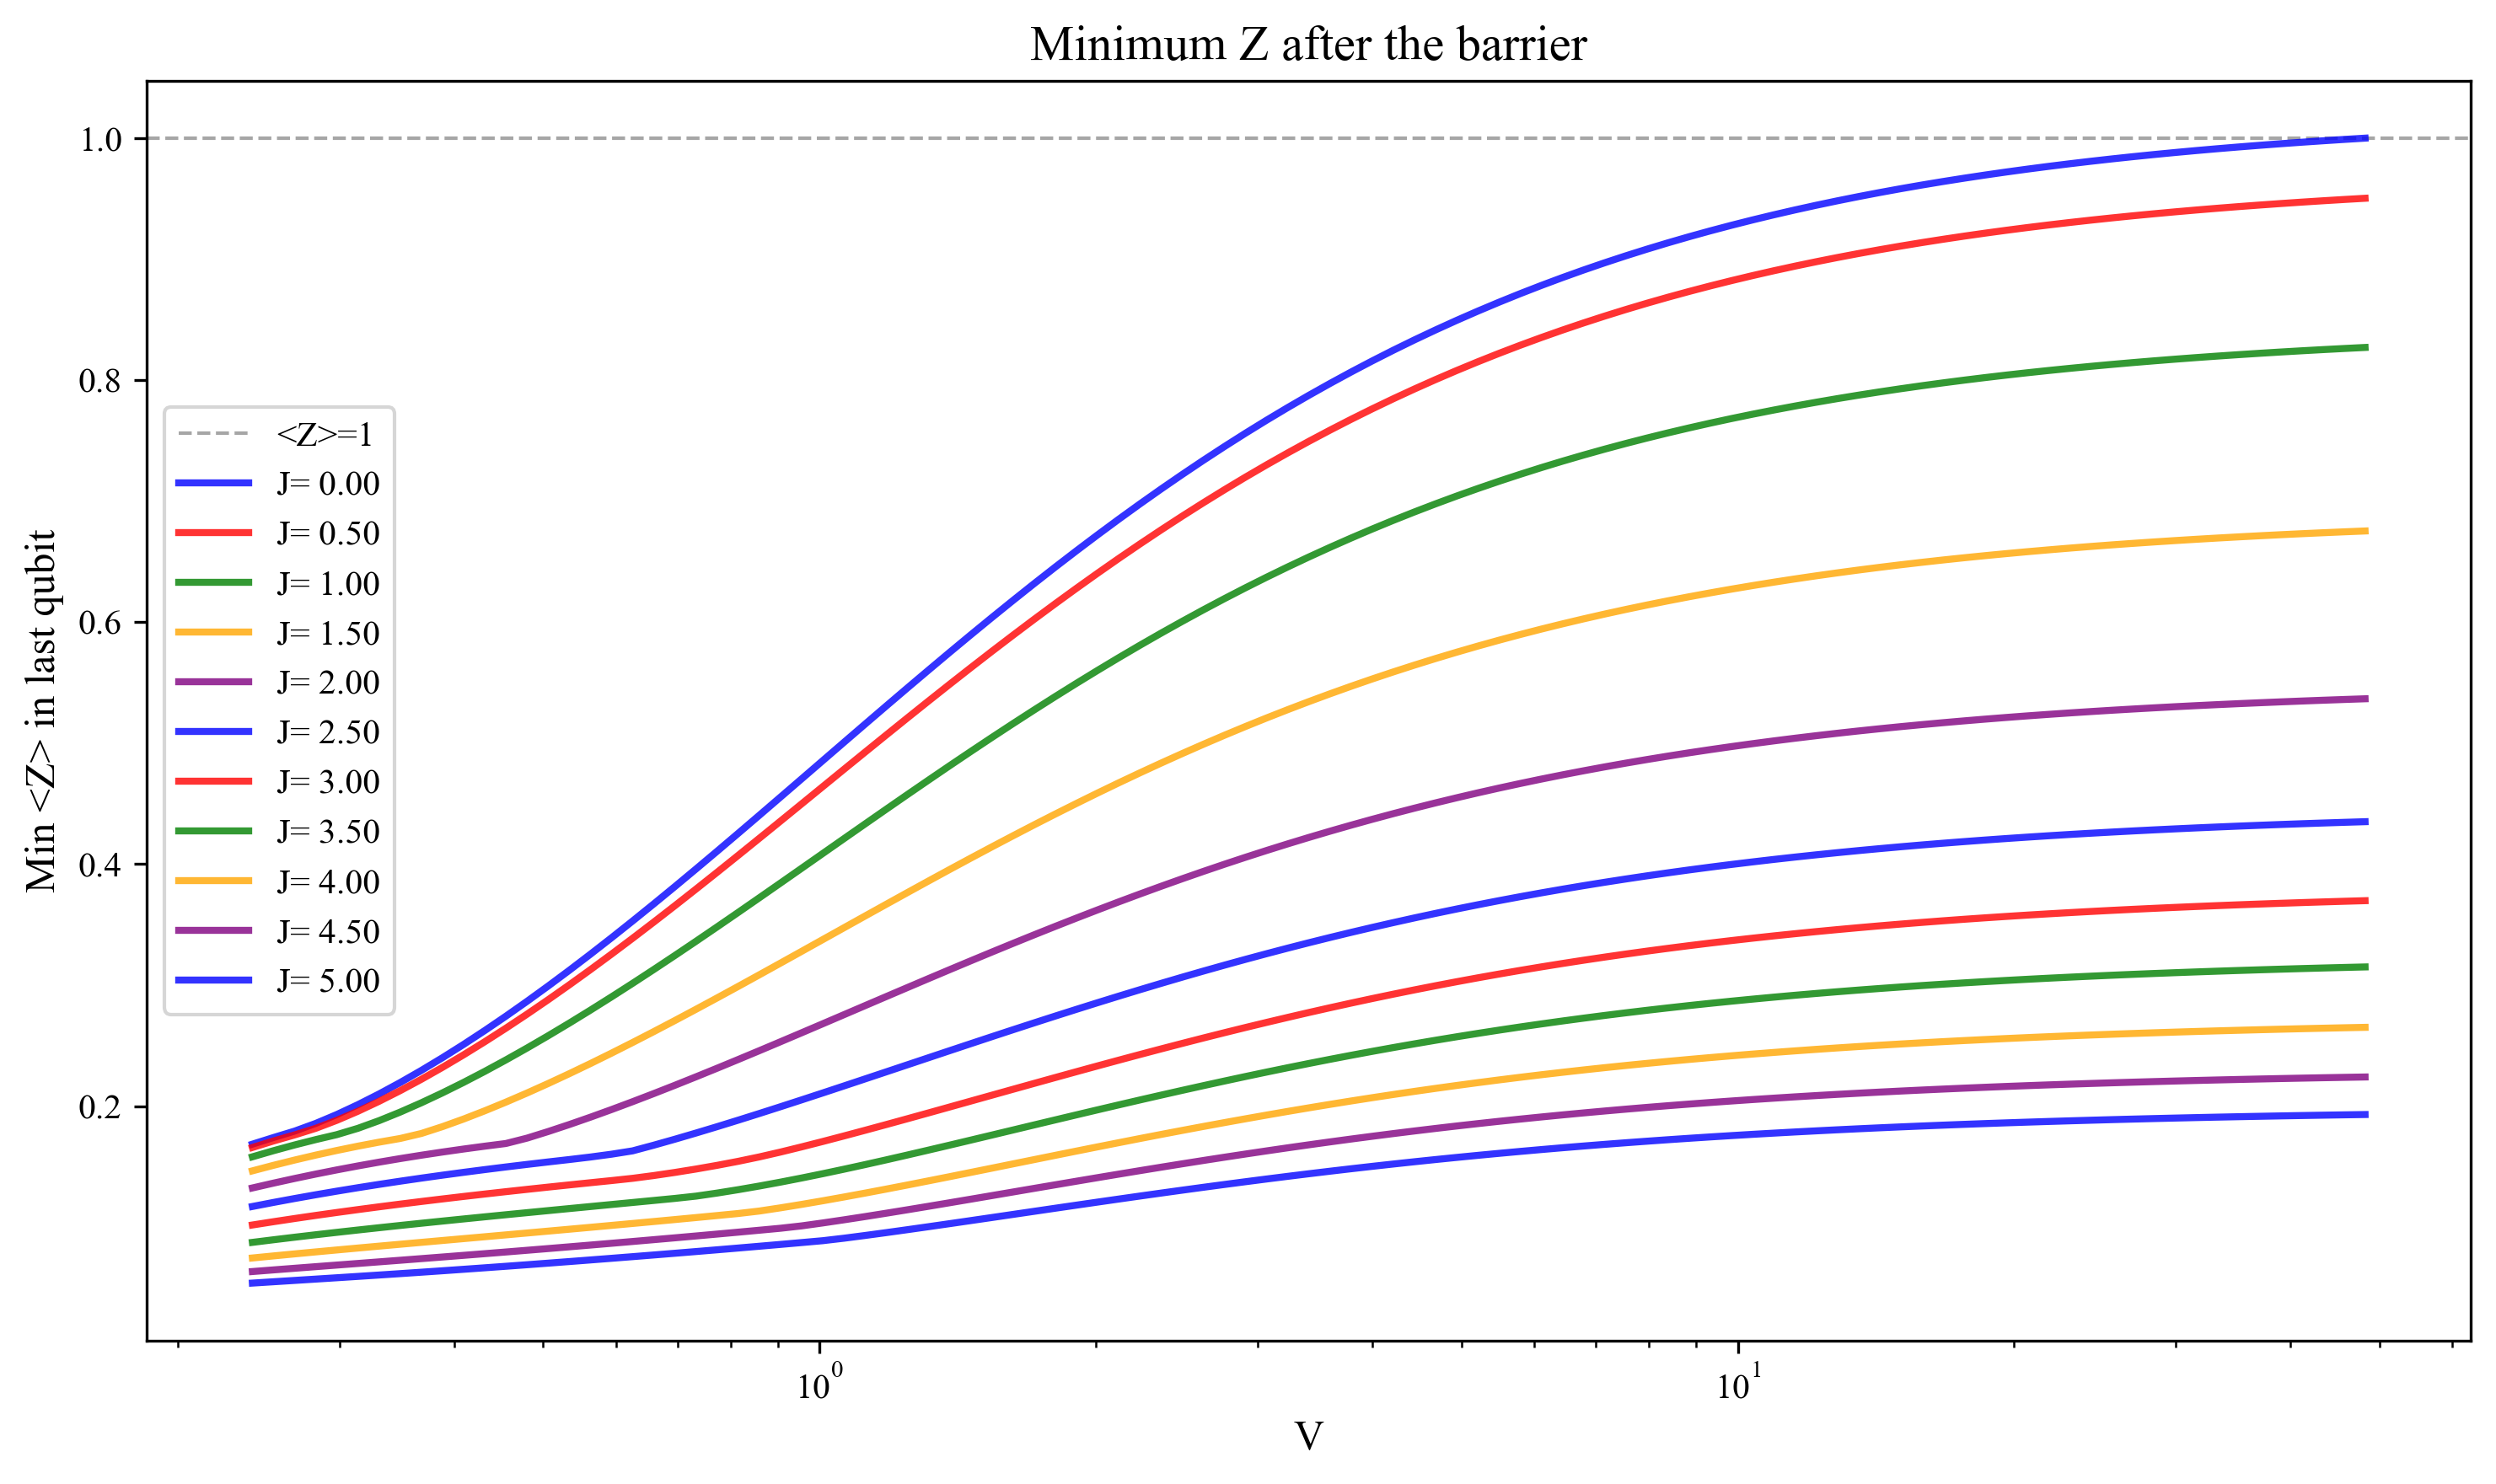

In [13]:
#data = min_z_last_qubit
data = transmission
# Create the plot
fig, ax = plt.subplots(figsize=(10, 6))

# Define colors for better distinction
colors = ['blue', 'red', 'green', 'orange', 'purple']

# Add dashed horizontal line at y=1
ax.axhline(y=1, color='gray', linestyle='--', linewidth=1, alpha=0.7, label='<Z>=1')

# Plot each line as solid lines
for i in range(data.shape[1]):
    color = colors[i % len(colors)]
    ax.plot(y_plot, data[:,i], 
            label=f'J= {x_plot[i]:.2f}', 
            color=color, 
            linewidth=2,           # Solid line with thickness 2
            linestyle='-',         # Explicitly set to solid line
            marker='',             # Remove markers for clean solid lines
            alpha=0.8)             # Slight transparency

# CONFIGURE AXIS BOUNDS - Adjust these values as needed
# Set x-axis limits

#ax.set_xlim(min(x), max(x))
ax.set_xscale("log")


# Customize the plot
ax.set_xlabel('V', fontsize=12)
ax.set_ylabel('Min <Z> in last qubit', fontsize=12)
ax.set_title('Minimum Z after the barrier', fontsize=14)
ax.legend(fontsize=10)


plt.tight_layout()
plt.show()